# Learning From Data HW06

# Overfitting and Deterministic Noise

# 1

Using a subset of the hypothesis set will in general increase the bias (the deterministic noise).

**Alternative B**

# Regularization with Weight Decay

Download training and test set.

In [20]:
import requests

try:
    with open("in.dta", "x") as f_in:
        request_in = requests.get("http://work.caltech.edu/data/in.dta")
        f_in.write(request_in.text)
        print("Downloaded training data")
except FileExistsError as e:
    print("Training data already downloaded")

try:
    with open("out.dta", "x") as f_out:
        request_out = requests.get("http://work.caltech.edu/data/out.dta")
        f_out.write(request_out.text)
        print("Downloaded test data")
except FileExistsError as e:
    print("Test data already downloaded")

Downloaded training data
Downloaded test data


Load data.

In [60]:
import numpy as np
data_train = np.loadtxt("in.dta")
X_train, y_train = data_train[:,:2], data_train[:,2]

data_test = np.loadtxt("out.dta")
X_test, y_test = data_test[:,:2], data_test[:,2]


Look at the data.

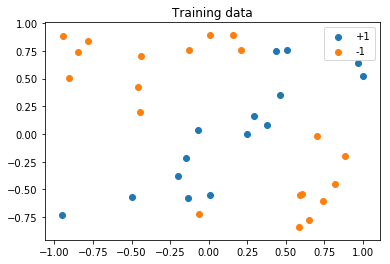

In [57]:
i_below = np.flatnonzero(y_training == -1)
i_above = np.flatnonzero(y_training == 1)
assert i_below.shape[0] + i_above.shape[0] == y_training.shape[0]

import matplotlib.pyplot as plt


plt.title("Training data")
plt.scatter(X_train[i_below,0], X_train[i_below,1])
plt.scatter(X_train[i_above,0], X_train[i_above,1])
plt.legend(["+1", "-1"])
plt.show()

# 2

Run linear regression on the training set after performing the non-linear transformation.

Since we already implemented nonlinear regression from scratch in the previous homework, I will use sklearn this time.

    class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)[source]¶

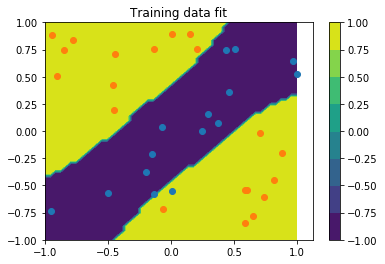

In [77]:
import sklearn as sk

def phi(X):
    Z = np.zeros((X.shape[0],  8))
    Z[:,0] = 1
    Z[:,1] = X[:,0]
    Z[:,2] = X[:,1]
    Z[:,3] = X[:,0]**2
    Z[:,4] = X[:,1]**2
    Z[:,5] = X[:,0] * X[:,1]
    Z[:,6] = np.abs(X[:,0] - X[:,1])
    Z[:,7] = np.abs(X[:,0] + X[:,1])
    return Z

# Transform the data
Z_train = phi(X_train)

# Fit the data
Z = Z_train
w_tilde = np.linalg.solve(Z.T @ Z, Z.T @ y_train)

def predict(X):
    Z = phi(X)
    return np.sign(Z @ w_tilde)

# View the contour
xx = np.linspace(-1, 1)
yy = np.linspace(-1, 1)
XX, YY = np.meshgrid(xx, yy)
X_plot = np.column_stack([XX.reshape(-1), YY.reshape(-1)])
y_plot = predict(X_plot)
ZZ = y_plot.reshape(XX.shape)
plt.title("Training data fit")
plt.contourf(XX, YY, ZZ)
plt.colorbar()
plt.scatter(X_train[i_below,0], X_train[i_below,1])
plt.scatter(X_train[i_above,0], X_train[i_above,1])
plt.show()

Compute in-sample classification error.

In [83]:
E_in = np.mean(predict(X_train) != y_train)
print("E_in =", E_in)

E_in = 0.02857142857142857


Compute of-of-sample classification error

In [85]:
E_out = np.mean(predict(X_test) != y_test)
print("E_out =", E_out)

E_out = 0.084


Which is most similar to **Alternative A: (0.03, 0.08)**

# 3

Add weight decay with $\lambda = 10^k$

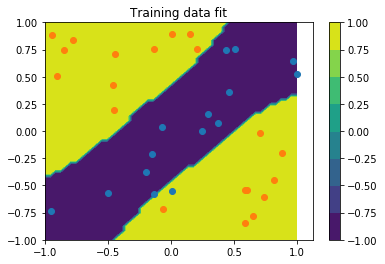

k -5
E_in = 0.02857142857142857
E_out = 0.084


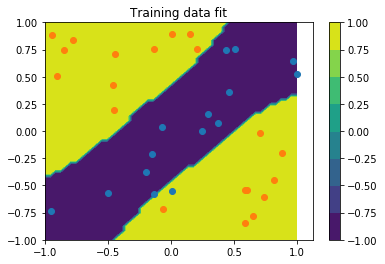

k -4
E_in = 0.02857142857142857
E_out = 0.084


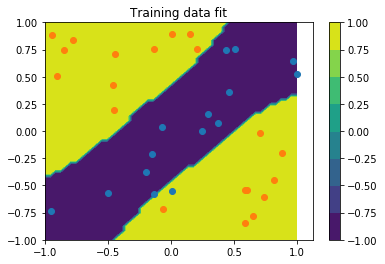

k -3
E_in = 0.02857142857142857
E_out = 0.08


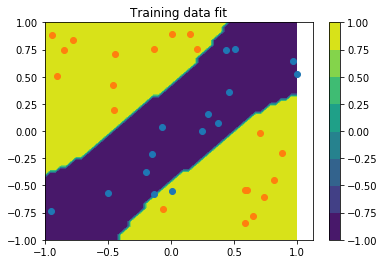

k -2
E_in = 0.02857142857142857
E_out = 0.084


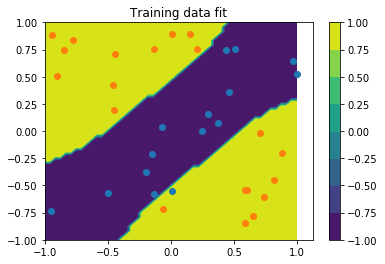

k -1
E_in = 0.02857142857142857
E_out = 0.056


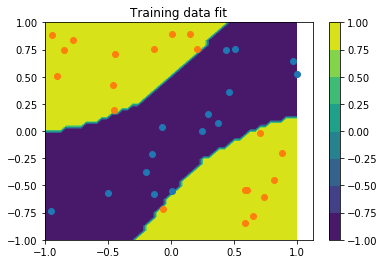

k 0
E_in = 0.0
E_out = 0.092


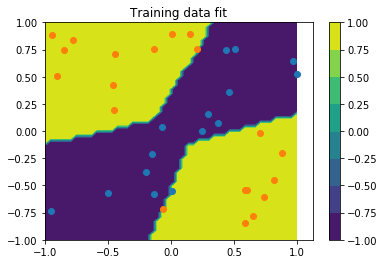

k 1
E_in = 0.05714285714285714
E_out = 0.124


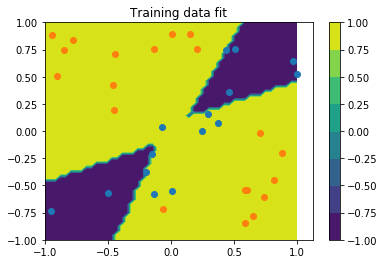

k 2
E_in = 0.2
E_out = 0.228


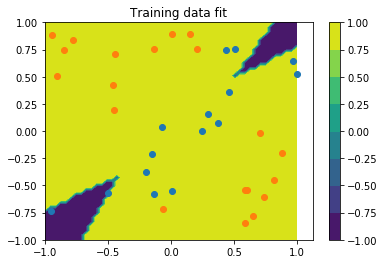

k 3
E_in = 0.37142857142857144
E_out = 0.436


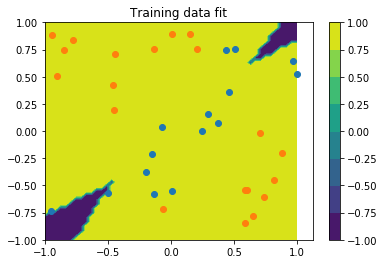

k 4
E_in = 0.42857142857142855
E_out = 0.452


In [110]:
# Transform the data
Z_train = phi(X_train)

for k in range(-5, 5):
    # Fit the data
    Z = Z_train
    w_tilde = np.linalg.solve(Z.T @ Z + 10**k*np.identity(Z.shape[1]), Z.T @ y_train)

    def predict(X):
        Z = phi(X)
        return np.sign(Z @ w_tilde)

    # View the contour
    xx = np.linspace(-1, 1)
    yy = np.linspace(-1, 1)
    XX, YY = np.meshgrid(xx, yy)
    X_plot = np.column_stack([XX.reshape(-1), YY.reshape(-1)])
    y_plot = predict(X_plot)
    ZZ = y_plot.reshape(XX.shape)
    plt.title("Training data fit")
    plt.contourf(XX, YY, ZZ)
    plt.colorbar()
    plt.scatter(X_train[i_below,0], X_train[i_below,1])
    plt.scatter(X_train[i_above,0], X_train[i_above,1])
    plt.show()

    # Print in/out error
    print("k", k)
    E_in = np.mean(predict(X_train) != y_train)
    print("E_in =", E_in)
    E_out = np.mean(predict(X_test) != y_test)
    print("E_out =", E_out)

For k=-3: Almost identical results. 0.03, 0.08. **3: Alternative D**

Better out of sample error with regularization. In sample is the same.

# 4

Need to compute euclidean distance to alternatives

In [97]:
E_in = 0.37142857142857144
E_out = 0.436
print("a", np.sqrt((E_in - 0.2)**2 + (E_out - 0.2)**2))
print("b", np.sqrt((E_in - 0.2)**2 + (E_out - 0.3)**2))
print("c", np.sqrt((E_in - 0.3)**2 + (E_out - 0.3)**2))
print("d", np.sqrt((E_in - 0.3)**2 + (E_out - 0.4)**2))
print("e", np.sqrt((E_in - 0.4)**2 + (E_out - 0.4)**2))

a 0.29169119819089645
b 0.21882357071860614
c 0.1536165382253048
d 0.07998775416478783
e 0.04596005364022374


**Alternative E** is the closest.

Both the in-sample and out-of-sample performance is just horrible.

# 5

The best choice for $k$ is -1, giving the lowest out-of-sample classification error. **Alternative C**

# 6

We get E_out = 0.056, closest to **Alternative B, 0.06**

# Regularization for Polynomials

## Interlude: Legendre polynomials

There are many ways to discover the Legendre polynomials. Instead of just importing them from sklearn or whatever I will take a stab at computing them myselves, using the following requirements:

1. Orthogonal over the interval [-1, 1]

$$ \int_{-1}^1 P_m(x) P_n(x)\,dx = 0\quad \text{ if } n \neq m $$

2. $P_n(x)$ has degree $n$

3. $ P_n(1) = 1 $ (standardization)

We can now use Gram-Schmidt orthogonalization to produce Legendre polynomials.

The scheme is defined by:

$$P_0(x) = 1 $$
(since that is the only zeroth order polynomial that fits).

$$P_n(x) = x^n - \frac{\langle x^n,P_{n-1}\rangle}{\langle P_{n-1}, P_{n-1}\rangle} P_{n-1}(x) - \cdots - \frac{\langle x^n,P_{0}\rangle}{\langle P_{0}, P_{0}\rangle} P_{0}(x)$$

We can now iteratively compute $P_1$, then $P_2$, ..., then $P_N$ for any desired $N$.

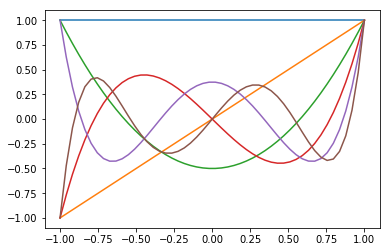

In [190]:
import sympy as sp
from sympy.abc import x
sp.init_printing() # Latex output
import matplotlib.pyplot as plt
import numpy as np

def inner(pi, pj):
    """Inner product between two polynomials"""
    return sp.integrate(pi*pj, (x, -1, 1))

def standardize(ptilde):
    """Standardize a polynomial so that P(1) = 1"""
    return ptilde / ptilde.subs(x, 1)

def legendre_polynomials(max_degree):
    """
    Return a list of Legendre polynomials up to `max_degree`.
    """
    ps = [
        sp.sympify("1")
    ]
    for n in range(1, max_degree+1):
        ptilde = x**n
        for j in range(0, n):
            ptilde = ptilde - inner(x**n, ps[j])/inner(ps[j], ps[j]) * ps[j]
        ps.append(standardize(ptilde))
    return ps

ps = legendre_polynomials(5)
for p in ps:
    display(p)

# Convert to NumPy functions and plot
fs = [sp.lambdify(x, p, "numpy") for p in ps]
xx = np.linspace(-1, 1)
for f in fs:
    # Broadcast needed for P0 since it returns "1" instead of [1 1 1 1...]
    plt.plot(xx, np.broadcast_to(f(xx), xx.shape))
plt.show()

Let us compare the results with SciPy's included functions.

 
1
 
1 x
     2
1.5 x - 0.5
     3
2.5 x - 1.5 x
       4             3        2
4.375 x + 4.857e-16 x - 3.75 x + 2.429e-16 x + 0.375
       5        3             2
7.875 x - 8.75 x - 4.372e-16 x + 1.875 x


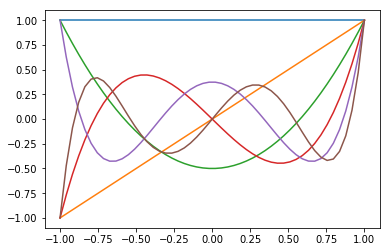

In [184]:
import scipy.special
sp_ps = [scipy.special.legendre(i) for i in range(6)]
for sp_p in sp_ps:
    print(sp_p)
    
for sp_p in sp_ps:
    plt.plot(xx, sp_p(xx))
plt.show()

Looks good to me!

I have now shown how it is possible to generate Legendre polynomials using symbolic Gram-Schmidt orthoganlization.

# 7

H(10, 0, 3) is equal to H2 since the weights for L3 and above are zero. Only the weights for L0, L1, L2 can be varied.

H(10, 0, 4) is a superset of H(10, 0, 3)

Thus the intersection of H(10, 0, 3) and H(10, 0, 4) is equal to H(10, 0, 3) which is again equal to H2.

**Alternative C** is correct.

# Neural Networks

# 8

My understanding is a bit lacking here, so I'll implement backpropagation from scratch to get used to it.

In [258]:
def activate(val):
    return np.tanh(val)


class Neuron:
    def __init__(self):
        self.input = 0.0
        self.activation = 0.0
        self.bias = 0.0
        self.weights 

        
class Layer:
    def __init__(self):
        self.neurons = [Neuron() for i in range(d)]
        
    def add_weights(self, prev_layer_d):
        for neuron in self.neurons:
            neuron.weights = np.random.rand(prev_layer_d+1)-0.5 

        
class NeuralNetwork:
    def __init__(self):
        self.layers = []
    
    def add_layer(self, d):
        self.layers.append(Layer(d))
    
        
        
        
        
nn = NeuralNetwork()
nn.add_layer(5)
nn.add_layer(3)
nn.add_layer(1)
    
nn.backprop(np.array([1, 0.3, -0.3, 0.4, 0.5, -0.1]), 5)

None
[[-0.30879981 -0.18594952 -0.09420257  0.22424713  0.35605223 -0.25057543]
 [-0.1082536  -0.19105748 -0.28573944 -0.39595402  0.48958064  0.27641807]
 [ 0.48829092 -0.3472206   0.20674335 -0.00358935 -0.20445817  0.40506152]]
[[ 0.33788974  0.06340615 -0.08913157 -0.06504361]]
None
[0. 0. 0. 0. 0.]
[0. 0. 0.]
[0.]
layer 2  neuron 1
  to neuron 1
  to neuron 2
  to neuron 3
layer 1  neuron 1
  to neuron 1
  to neuron 2
  to neuron 3
  to neuron 4
  to neuron 5
layer 1  neuron 2
  to neuron 1
  to neuron 2
  to neuron 3
  to neuron 4
  to neuron 5
layer 1  neuron 3
  to neuron 1
  to neuron 2
  to neuron 3
  to neuron 4
  to neuron 5


In [290]:
W1 = np.array([
    [0.1, -0.1, 0.2],
    [-0.1, 0.2, -0.5]
])

W2 = np.array([
    [-0.1, 0.1, 0.4],
])


# Input
x0 = np.array([
    [1],
    [2],
    [3],
])

# Forward-pass (prediction)
# Forward pass layer 1
s1 = W1 @ x0
print("\ns1\n", s1)
x1 = np.vstack([[[1]], np.tanh(s1)])
print("\nx1\n", x1)

# Forward pass layer 2
s2 = W2 @ x1
print("\ns2\n", s2)
x2 = np.vstack([[[1]], np.tanh(s2)])
print("\nx2\n", x2)

print("\nPredicted", x2[1][0])

# Square error
y = -1
e = (x2[1][0] - y)**2

# Backpropagation to find de/dw[l]_ji for all l,j,i

# e = e(x) = e(x(s)) = e(x(s(w)))
# de/dw = de/dx * dx/ds * ds/dw

# Layer 2 weights
# dell2[1] = de/dx2[1] * dx2[1]/ds2[1]
# de/dw2[1,0] = de/dx2[1] * dx2[1]/ds2[1] * ds2[1]/dw2[1,0] = dell2[1] * ds2[1]/dw2[1,0]
# de/dw2[1,1] = de/dx2[1] * dx2[1]/ds2[1] * ds2[1]/dw2[1,1] = dell2[1] * ds2[1]/dw2[1,1]
# de/dw2[1,2] = de/dx2[1] * dx2[1]/ds2[1] * ds2[1]/dw2[1,2] = dell2[1] * ds2[1]/dw2[1,2]


#

# Layer 1 weights
# dell1[1] = de/dx1[1] * dx1[1]/ds1[1]
# dell1[1] = de/dx1[1] * dx1[1]/ds1[1]


s1
 [[ 0.5]
 [-1.2]]

x1
 [[ 1.        ]
 [ 0.46211716]
 [-0.83365461]]

s2
 [[-0.38725013]]

x2
 [[ 1.        ]
 [-0.36898717]]

Predicted -0.36898716821053856
